# Sensor grid data with ANN using Keras

Experiment 1: Each sensor reading is treated as an individual sample. 10% of training data was selected for validation. 

train: validation: test = 365028 : 40559 : 45066

Machine learning method: ANN

Feature Scaling Required : Yes

## Outputs:

- Keras training history: `../Models/ANN/trainHistoryDict.pickle`
- Keras training log: `../Models/ANN/training.csv`
- Training checkpoint (best validation loss only) & final model: `../Models/ANN/model.hdf5`
- Testing set predictions: `../Models/ANN/predictions_MLP.npy`

## Warning:
To prevent overwriting saved results when running this notebook, I added time to the name of saved training objects in "train model" cell.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras import regularizers
import tensorflow as tf

from functions.functions import load_data_forGridSearch, feature_scaling_forGridSearch, save_object
#from functions.functions_metrics import evaluate_generic_metrics

import pickle
import time

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

print(np.__version__)
# np.random.seed(4999)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.14.4


In [2]:
timestr = time.strftime("%Y%m%d-%H%M%S")

In [3]:
# load training and testing data
X_train, y_train = load_data_forGridSearch("../Data", "train")
X_test, y_test = load_data_forGridSearch("../Data", "test")


In [4]:
# perform feature scaling
X_train_transformed, X_test_transformed = feature_scaling_forGridSearch(X_train, X_test)

In [5]:

# This is only used to display R2 during training, not used for updating weights or final evaluation 

def R2_score(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    R2 = 1. - tf.div(numerator, denominator)
    R2_mean = tf.reduce_mean(R2)
    return R2_mean


    

In [6]:
# build model structure

model = Sequential()
model.add(Dense(units=100,
                activation="tanh",
                input_dim = X_train_transformed.shape[1]))
model.add(Dense(units=50, activation="tanh"))
model.add(Dense(units=25, activation="tanh"))
model.add(Dense(units=y_train.shape[1]))

model.summary()

# compile model
model.compile(loss="mean_squared_error", optimizer="adam", metrics = [R2_score])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 78        
Total params: 7,603
Trainable params: 7,603
Non-trainable params: 0
_________________________________________________________________


In [7]:
# train model

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

model_checkpoint = ModelCheckpoint('../Models/ANN/model_{}.hdf5'.format(timestr),
                                   monitor='val_loss', verbose=0, save_best_only=True)
csv_logger = CSVLogger('../Models/ANN/training_{}.csv'.format(timestr))
callbacks = [early_stop, model_checkpoint, csv_logger]


history = model.fit(X_train_transformed, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.1,
                    callbacks =callbacks,
                    verbose = 2,
                    shuffle = True)

with open('../Models/ANN/trainHistoryDict_{}.pickle'.format(timestr), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Train on 346040 samples, validate on 38449 samples
Epoch 1/50
 - 14s - loss: 6.3220e-04 - R2_score: 0.3895 - val_loss: 2.1743e-04 - val_R2_score: 0.5162
Epoch 2/50


KeyboardInterrupt: 

## Testing

In [8]:
# load model with the lowest val_loss
# load model with custom metrics or loss
# ref: https://github.com/keras-team/keras/issues/5916

#model = load_model('../Models/ANN/model.hdf5', custom_objects={'R2_score': R2_score})

model = load_model('../Models/ANN/model_{}.hdf5'.format(timestr), custom_objects={'R2_score': R2_score})

In [18]:
# we need to create a dummy tuple because we expect a Keras history object and not just the dict
from collections import namedtuple
HistoryTuple = namedtuple('History', 'history')
with open('../Models/ANN/trainHistoryDict_20190605-111346.pickle', 'rb') as f:
    history = HistoryTuple(pickle.load(f))

In [9]:
# this will export the model as a TensorFlow compatible protocol buffers file
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
    
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, '../Models/ANN/', 'model_{}.pb'.format(timestr), as_text=False)

INFO:tensorflow:Froze 74 variables.
Converted 74 variables to const ops.


'../Models/ANN/model_20190605-111346.pb'

In [10]:
y_pred_train = model.predict(X_train_transformed)
print("ANN model R2 on training set: " + str(r2_score(y_true = y_train, y_pred = y_pred_train)))

y_pred_test = model.predict(X_test_transformed)
print("ANN model R2 on testing set: " + str(r2_score(y_true = y_test, y_pred = y_pred_test)))

# save test predictions
np.save('../Models/ANN/predictions_ANN.npy', y_pred_test)
#np.save('keras_MLP/predictions_ANN.npy', y_pred_test)

ANN model R2 on training set: 0.9869820012042766
ANN model R2 on testing set: 0.9867849952574006


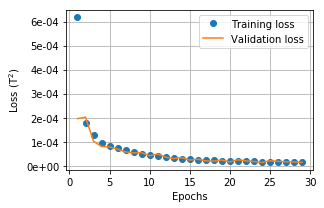

In [32]:
# plot training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(4.6,3))
plt.plot(epochs, loss, 'o', label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
#plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (T$^2$)')
plt.gca().get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.0e'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/ann_training_loss.pdf')

#plt.show()


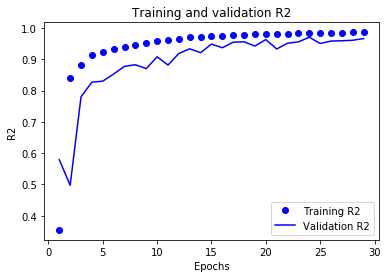

In [20]:
# plot training and validation R2 metrics

plt.clf() # clears the figure

r2 = history.history['R2_score']
val_r2 = history.history['val_R2_score']

epochs = range(1, len(loss)+1)

plt.plot(epochs, r2, 'bo', label = 'Training R2')
plt.plot(epochs, val_r2, 'b', label = 'Validation R2')
plt.title('Training and validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.tight_layout()

plt.show()